In [ ]:
!pip install pmdarima

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


In [ ]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('/content/TCS.NS (5).csv',index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(method='ffill')

In [ ]:
stock_data


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,124.262497,127.175003,123.537498,124.574997,93.246559,5375740.0
2009-01-05,125.500000,130.750000,124.500000,128.812500,96.418396,4829776.0
2009-01-06,128.750000,130.500000,124.562500,126.599998,94.762321,5918992.0
2009-01-07,129.750000,129.949997,116.150002,126.199997,94.462914,9013828.0
2009-01-09,124.974998,137.449997,121.250000,134.237503,100.479088,14219980.0
...,...,...,...,...,...,...
2019-12-23,2210.000000,2241.949951,2210.000000,2231.699951,2073.331055,2247329.0
2019-12-24,2239.000000,2243.550049,2211.149902,2215.600098,2058.374512,1805896.0
2019-12-26,2216.399902,2229.000000,2195.199951,2201.949951,2045.692383,1880367.0


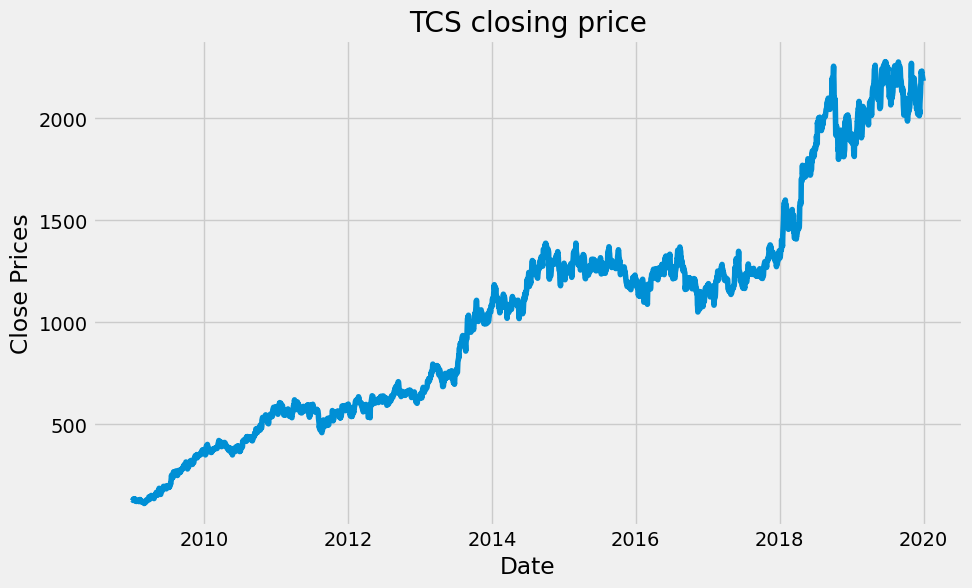

In [ ]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('TCS closing price')
plt.show()


<Axes: ylabel='Density'>

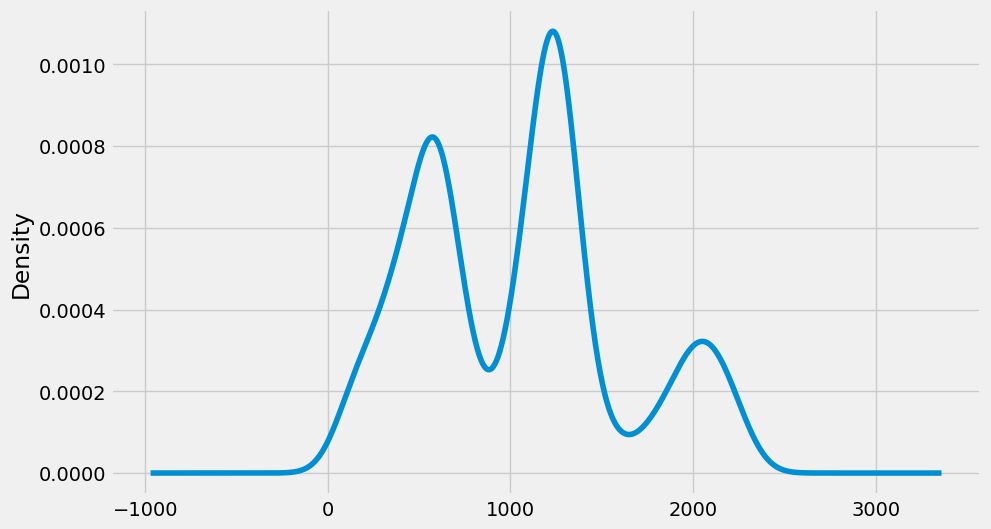

In [ ]:
#Distribution of the dataset
df_close=stock_data['Close']
df_close.plot(kind='kde')



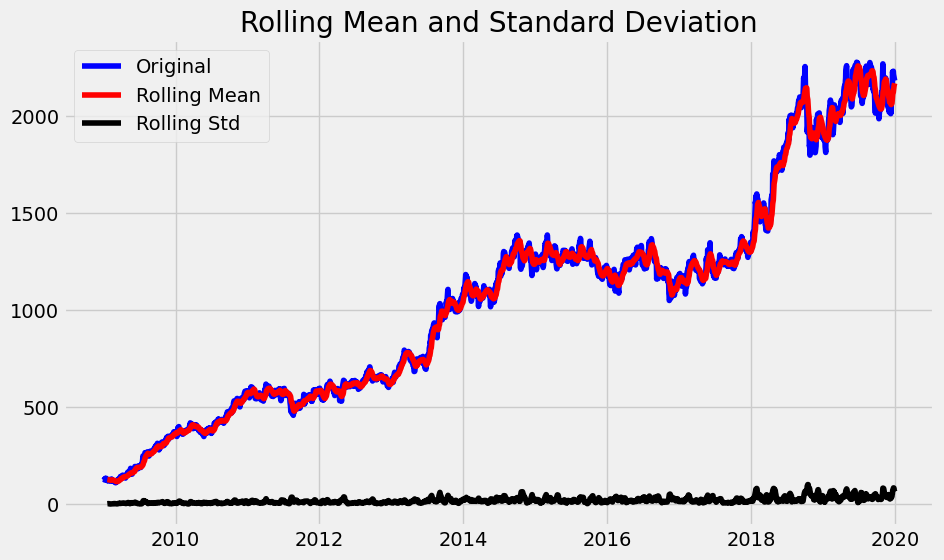

Results of dickey fuller test
Test Statistics                  -0.058215
p-value                           0.953445
No. of lags used                 21.000000
Number of observations used    2689.000000
critical value (1%)              -3.432784
critical value (5%)              -2.862615
critical value (10%)             -2.567342
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df_close)

<Figure size 1000x600 with 0 Axes>

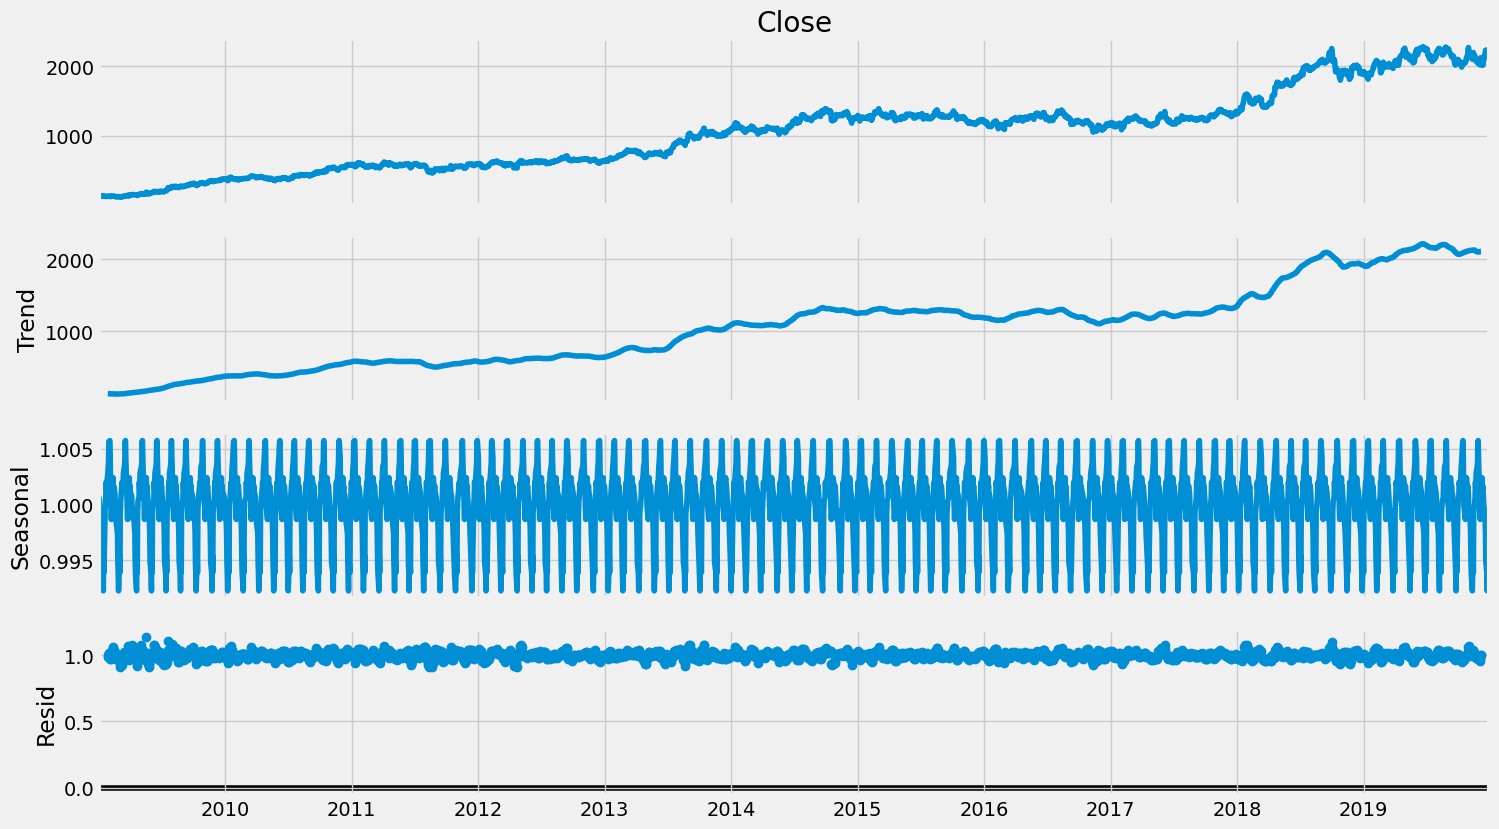

In [ ]:
#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)


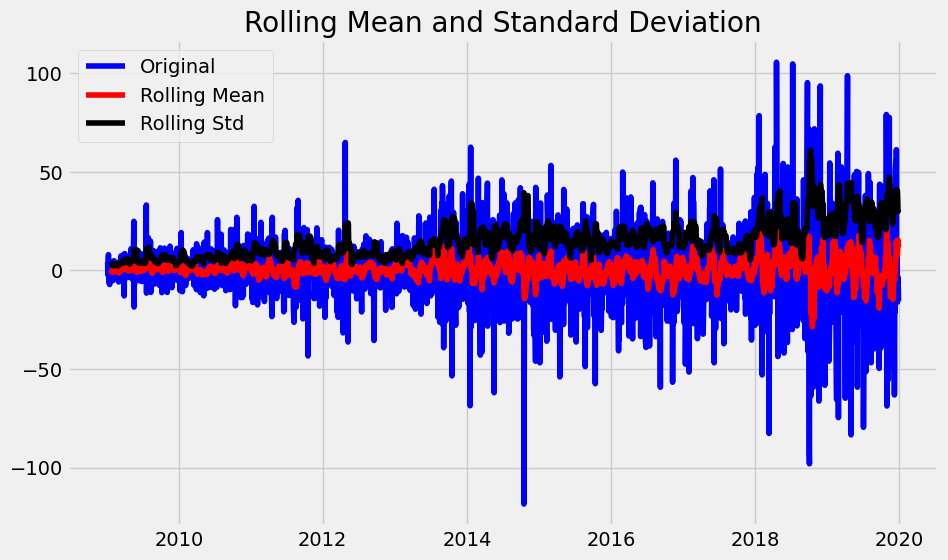

Results of dickey fuller test
Test Statistics               -1.267595e+01
p-value                        1.215794e-23
No. of lags used               2.800000e+01
Number of observations used    2.681000e+03
critical value (1%)           -3.432791e+00
critical value (5%)           -2.862619e+00
critical value (10%)          -2.567344e+00
dtype: float64


In [ ]:
from pmdarima.arima.utils import ndiffs
d_val = ndiffs(df_close, test='adf')
test_stationarity(df_close.diff()[1:])

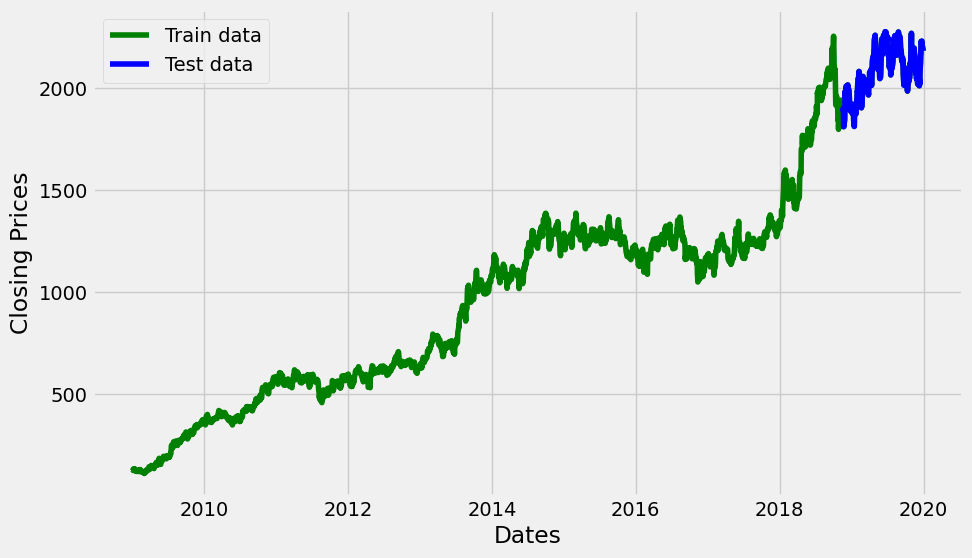

In [ ]:
#split data into train and training set
train_data, test_data = df_close[3:int(len(df_close)*0.9)], df_close[int(len(df_close)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


In [ ]:
train_data

Date
2009-01-07     126.199997
2009-01-09     134.237503
2009-01-12     128.137497
2009-01-13     131.412506
2009-01-14     134.737503
                 ...     
2018-11-09    1909.199951
2018-11-12    1914.849976
2018-11-13    1934.949951
2018-11-14    1880.650024
2018-11-15    1872.849976
Name: Close, Length: 2436, dtype: float64

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=20315.317, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=20317.317, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=20317.351, Time=0.74 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=20317.964, Time=1.02 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=20317.317, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=20316.416, Time=1.63 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=20315.814, Time=2.21 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=20317.451, Time=2.05 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=20317.468, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=20315.711, Time=4.22 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=20313.089, Time=9.48 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=20314.451, Time=13.11 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=20318.348, Time=1.02 sec
 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=20317.268, Time=6.78 sec
 ARIMA(3,1,2)(0,0,0)[1] intercept   : AIC=20319.645, Time=4.0

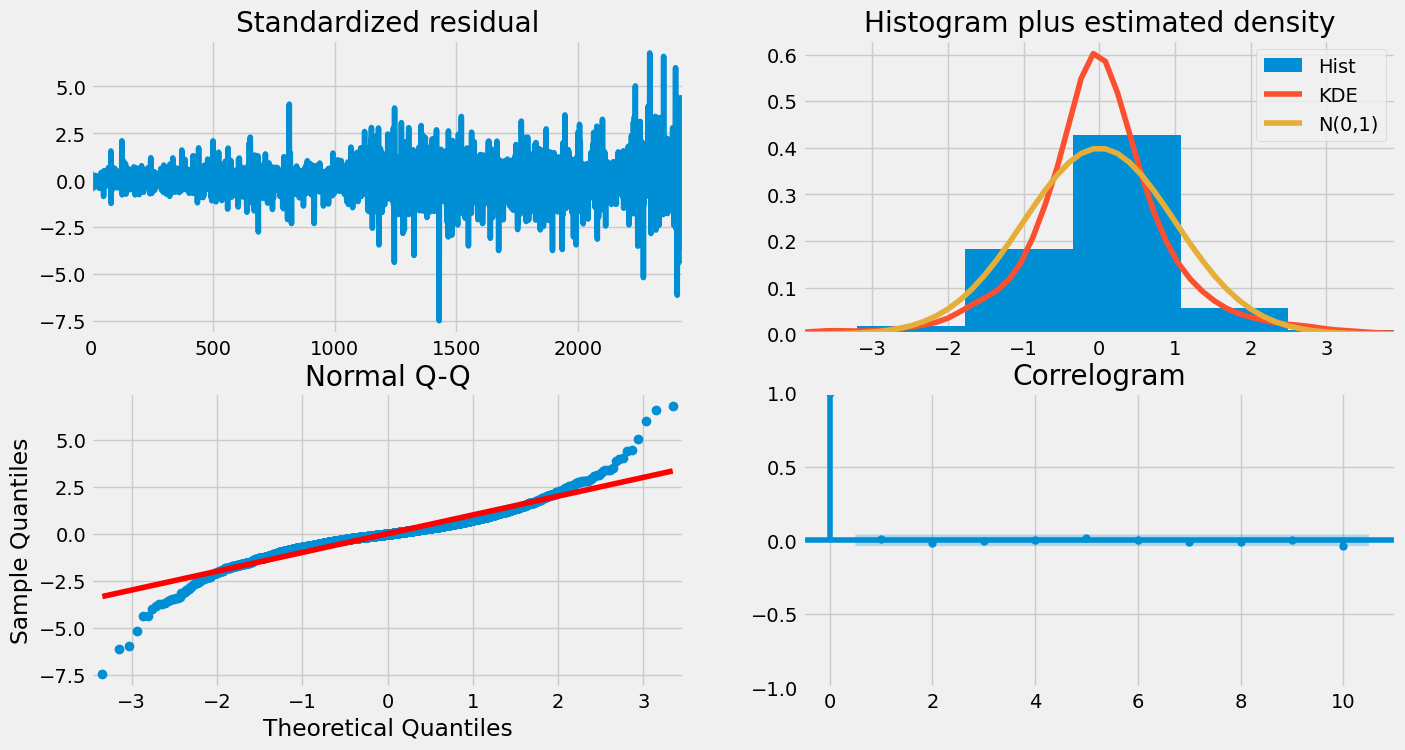

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=d_val,          # computed d till stationarity
                      seasonal=True,   # Seasonality
                      stepwise=False,
                      max_order=30,
                      trace=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()


In [ ]:
import statsmodels.api as sm

#Modeling
# Build Model
model = sm.tsa.statespace.SARIMAX(train_data, trend='t',seasonality=(1,1,1, 60),order=(2,1,2))
fitted = model.fit()
print(fitted.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2436
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -10155.014
Date:                Thu, 24 Aug 2023   AIC                          20322.028
Time:                        19:51:43   BIC                          20356.815
Sample:                             0   HQIC                         20334.674
                               - 2436                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0005      0.000      1.204      0.229      -0.000       0.001
ar.L1       6.713e-05      0.554      0.000      1.000      -1.086       1.086
ar.L2         -0.0140      0.527     -0.027      0.9

In [ ]:
fc = fitted.forecast(steps=272, alpha=0.05)  # 95% confidence interval
conf = fitted.get_forecast(272).summary_frame()


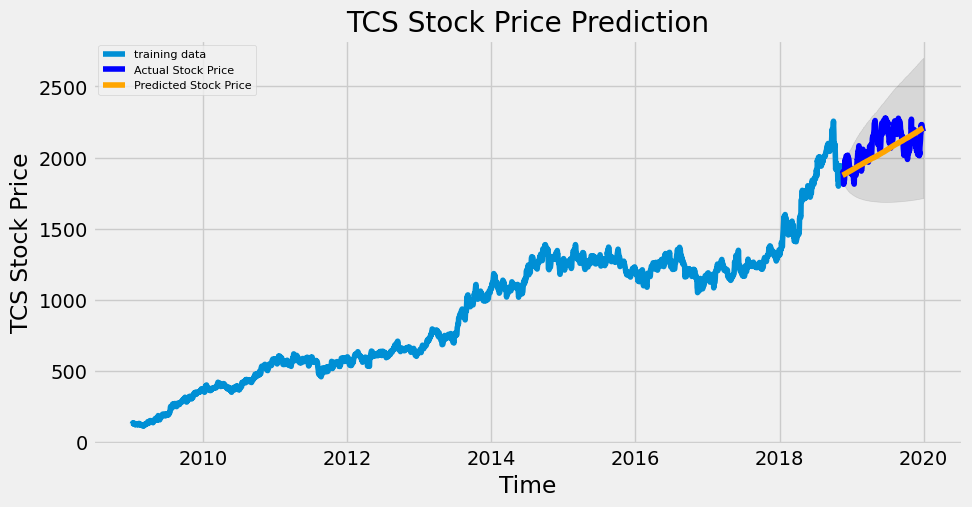

In [ ]:
# Make as pandas series
fc_series = pd.Series(fc.values, index=test_data.index)
lower_series = pd.Series(conf['mean_ci_lower'].values, index=test_data.index)
upper_series = pd.Series(conf['mean_ci_upper'].values, index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.10)

plt.title('TCS Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TCS Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [ ]:
# report performance
mse = mean_squared_error(test_data, fc_series)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc_series)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc_series))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc_series - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 10641.536163425217
MAE: 84.63465921839213
RMSE: 103.15782162989493
MAPE: 0.03990479192217777


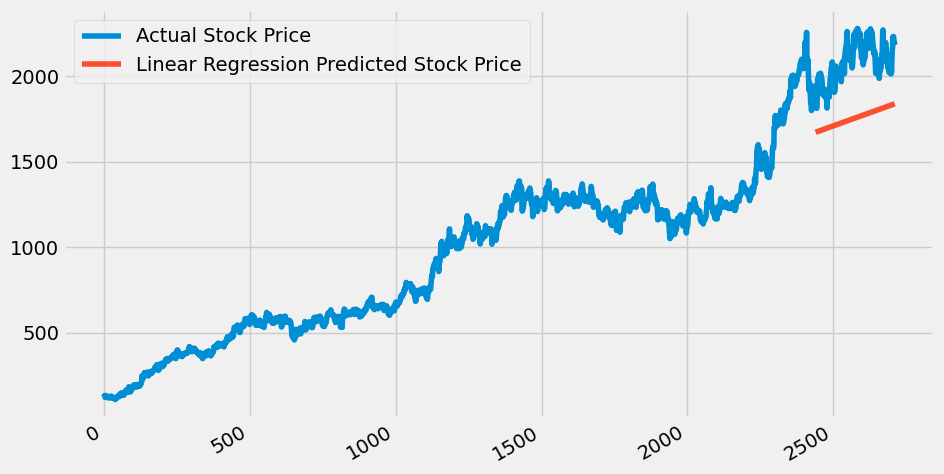

In [ ]:
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


total = len(df_close)
aaa = len(test_data)
hist = total - aaa


# Linear Regression Model
regressor = LinearRegression()
X = np.arange(hist).reshape(-1, 1)
y = df_close.values[:hist]
regressor.fit(X, y)

# Predict stock prices using Linear Regression
linear_result = regressor.predict(np.arange(hist, hist + aaa).reshape(-1, 1))

# Plotting Linear Regression predictions
ind = np.arange(total)

fig, ax = plt.subplots()
ax.plot(ind, df_close.values, label='Actual Stock Price')
ax.plot(ind[hist:], linear_result, label='Linear Regression Predicted Stock Price')
ax.legend()
fig.autofmt_xdate()
plt.show()


In [ ]:
# report performance
mse = mean_squared_error(test_data, linear_result)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, linear_result)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, linear_result))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(linear_result - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 115885.67306493579
MAE: 327.86846323544967
RMSE: 340.4198482241243
MAPE: 0.15565546162774985
